# Regression Analysis for Predicting Birth Weights

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import pylab
import datetime
import itertools
import scipy.stats as stats
from functools import reduce
from string import punctuation
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Functions 

In [2]:
#groupby function
def groupby(df, group_list, calc_column, calculations):
    group = df.groupby(group_list).agg({calc_column: calculations}).reset_index()
    group.columns = ['_'.join(col) for col in group.columns]
    group.columns = [col.strip(punctuation) for col in group.columns]
    group_count = df.groupby(group_list)[calc_column].count().reset_index()
    group_count.columns = [col if col in group_list else 'count_'+col for col in group_count.columns]
    final = pd.merge(group, group_count, on=group_list, how='left')
    return final

In [3]:
#All combinations data analysis algorithm
def combinations_calculations(df, groupby_list, calc_column, calculations, groupby_function, n):
    start = datetime.datetime.now()
    
    output_df = pd.DataFrame()
    
    for L in range(0, len(groupby_list)+1):
        for subset in itertools.combinations(groupby_list, L):
            df2 = df.copy()
            
            if len(groupby_list) > n:
                df2 = df2[groupby_list]
                df2.drop_duplicates(groupby_list, keep='first', inplace=True)
                
                for element in calc_column:
                    df_groupby = groupby_function(df, groupby_list, element, calculations)
                    df2 = pd.merge(df2, df_groupby, on=groupby_list, how='left')
            
                output_df = output_df.append(df2, ignore_index=True, sort=False)
            else:
                pass
            
    for column in groupby_list:
        output_df[column].fillna('All', inplace=True)
    
    end = datetime.datetime.now()
    elapsed_time = (end - start)
    runtime = elapsed_time / datetime.timedelta(minutes=1)
    print("Runtime: {}".format(runtime))
    
    return output_df

In [4]:
#Correlation matrix
def corrmatrix(df):
    corrMatrix = df.corr()
    return corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

In [5]:
#function to create an OLS regression Model using statsmodels package
def create_ols_model(x, y):
    lr = sm.OLS(np.log(y), x)
    model = lr.fit()
    return model

In [6]:
#Calculate metrics for Regression Model
def regression_metrics(model, xtest, y_true): 
    predictions = model.predict(xtest)
    y_true = np.ravel(np.log(y_true))
    dof_ratio = len(xtest) / (len(xtest.columns)-1)
    mape = np.mean(np.abs((y_true - predictions) / y_true)) * 100
    mse = np.mean((y_true - predictions) ** 2)
    rmse = np.sqrt(np.mean((y_true - predictions) ** 2))
    
    metrics_df = pd.DataFrame({'MAPE':mape,
                               'MSE': mse,
                               'RMSE': rmse,
                               'DOF Ratio': dof_ratio}, index=[1])
    
    return mape, mse, rmse, dof_ratio, metrics_df

In [7]:
def x_y_split(df, x_vars, y_vars, categoricals, drop_elements):
    x = df.copy()
    x = x[x_vars]
    x = pd.get_dummies(x, columns=categoricals)
    
    
    drop_columns = [i + '_' + j for i, j in zip(categoricals, drop_elements)]
    
    x = x.drop(drop_columns, axis=1)
    x = sm.add_constant(x)
    
    y = df.copy()
    y = y[[y_vars]]
    
    return x, y

In [8]:
def qq_plot(df, column):
    distribution = df[column]
    stats.probplot(distribution, dist="norm", plot=pylab)
    return pylab.show()

In [9]:
def get_predictions(model, x, y):
    predictions = model.predict(x)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'Prediction'}, inplace=True)
    dfs = [x, y, predictions]
    output_df = reduce(lambda  left, right: pd.merge(left, right,
                                                     left_index=True, right_index=True, how='inner'), dfs)
    
    coefficient_df = model.summary2().tables[1].reset_index()
    coefficient_df.rename(columns={'index':'Variables'}, inplace=True)
    coefficient_df['Exponentiated Coefficient'] = np.exp(coefficient_df['Coef.'])-1
    
    prediction_intervals = model.get_prediction(x)
    prediction_intervals = prediction_intervals.summary_frame()
    prediction_intervals.rename(columns={'obs_ci_lower': 'Lower Prediction Interval', 'obs_ci_upper':'Upper Prediction Interval'},
                                  inplace=True)


    output_df = pd.merge(output_df, prediction_intervals[['Lower Prediction Interval', 'Upper Prediction Interval']], 
                         left_index=True, right_index=True, how='inner')
    
    
    output_df['Log Birth Weight'] = np.log(output_df['BirthWeightOz'])
    output_df['Residual'] = output_df['Log Birth Weight'] - output_df['Prediction']
    
    output_df['Exponentiated Prediction'] = np.exp(output_df['Prediction'])
    output_df['Exponentiated Upper Limit'] = np.exp(output_df['Upper Prediction Interval'])
    output_df['Exponentiated Lower Limit'] = np.exp(output_df['Lower Prediction Interval'])
    
    output_df['Lower Limit Outlier'] = np.where(output_df['Log Birth Weight'] < output_df['Lower Prediction Interval'],1,0)
    output_df['Upper Limit Outlier'] = np.where(output_df['Log Birth Weight'] > output_df['Upper Prediction Interval'],1,0)
    
    return output_df, coefficient_df  

### External Data Tables

In [10]:
sn.set()
data = pd.read_csv(r'C:\Users\nickp\Desktop\data science\baby weight\births.csv')
print("Dataset Length: {}".format(len(data)))
data.head()

Dataset Length: 1409


,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie,MomRace
0,1,1,32,40,1,38,0,111,0,0,white
1,1,2,32,37,1,34,0,116,0,0,white
2,1,1,27,39,1,12,0,138,0,0,white
3,1,1,27,39,1,15,0,136,0,0,white
4,1,1,25,39,1,32,0,121,0,0,white


### Data Exploration and Preprocessing

###### Dictionaries for Mapping binary indicators to categories

In [11]:
#Dictionaries for mapping
gender = {1: 'male',
       2: 'female'}

marital_status = {1: 'married',
                 2: 'not married'}

smoker = {1: 'yes',
         0: 'no'}

#premature defined as less than 36 weeks
premie = {0: 'no',
         1: 'yes'}

In [12]:
#lists for mapping dictionaries to new columns

numeric_to_categorical_dicts = [gender, marital_status, smoker, premie]
mapping_columns_list = ['Sex', 'Marital', 'Smoke', 'Premie']
new_column_name_list = ['Gender', 'Marital Status', 'Smoker', 'Premie Baby']

#Zip above lists to run mapping of dictionaries
for a, b, c in zip(numeric_to_categorical_dicts, mapping_columns_list, new_column_name_list):
    data[c] = data[b].map(a)

In [13]:
categorical_columns = ['Gender', 'Marital Status', 'Smoker', 'Premie Baby', 'MomRace']

for i in categorical_columns:
    data[i] = data[i].str.lower()
    data[i] = data[i].str.title()
    data[i] = data[i].str.strip()

### Exploratory Analysis

In [14]:
#check null values
data.isnull().sum()

Plural            0
Sex               0
Mom Age           0
Weeks             0
Marital           0
Weight Gained     0
Smoke             0
BirthWeightOz     0
Low               0
Premie            0
MomRace           0
Gender            0
Marital Status    0
Smoker            0
Premie Baby       0
dtype: int64

In [15]:
#summary statistics
data.describe()

,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie
count,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.00000
mean,1.036196,1.488999,26.792761,38.649397,1.344925,30.589780,0.146203,116.440738,0.084457,0.12846
std,0.201475,0.500056,6.089151,2.654167,0.475513,13.875535,0.353435,22.125534,0.278171,0.33472
min,1.000000,1.000000,13.000000,22.000000,1.000000,0.000000,0.000000,12.000000,0.000000,0.00000
25%,1.000000,1.000000,22.000000,38.000000,1.000000,20.000000,0.000000,106.000000,0.000000,0.00000
50%,1.000000,1.000000,26.000000,39.000000,1.000000,30.000000,0.000000,118.000000,0.000000,0.00000
75%,1.000000,2.000000,31.000000,40.000000,2.000000,40.000000,0.000000,130.000000,0.000000,0.00000
max,3.000000,2.000000,43.000000,45.000000,2.000000,95.000000,1.000000,181.000000,1.000000,1.00000


###### Get statistics on different dimensions of the data

In [16]:
#Lists for combinations groupby analysis
combinations = ['Marital Status', 'Smoker', 'Gender']
statistics = ['min', 'mean', 'max']
calculation_columns = ['BirthWeightOz']
min_combinations = 0


#DataFrame returning statistics across different groups of categorical variables
combinations_df = combinations_calculations(data, combinations, calculation_columns, statistics, 
                                                      groupby, min_combinations)

combinations_df.head()

Runtime: 0.010944783333333333


,Marital Status,Smoker,Gender,BirthWeightOz_min,BirthWeightOz_mean,BirthWeightOz_max,count_BirthWeightOz
0,Married,No,Male,21,121.557692,181,416
1,Married,No,Female,25,118.695122,166,410
2,Not Married,No,Female,12,110.450000,165,180
3,Not Married,Yes,Female,78,110.777778,146,54
4,Married,Yes,Female,70,109.933333,137,45


###### Charts and Visualizations

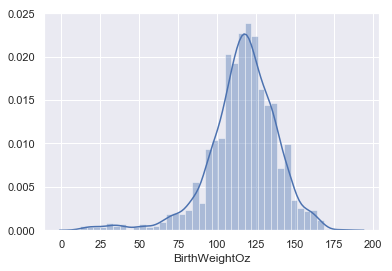

In [17]:
#Distribution plot of y variable
sn.distplot(data['BirthWeightOz'], axlabel = 'BirthWeightOz')

Text(0.5, 1.0, 'Boxplot of Birth Weights By Smoker Type')

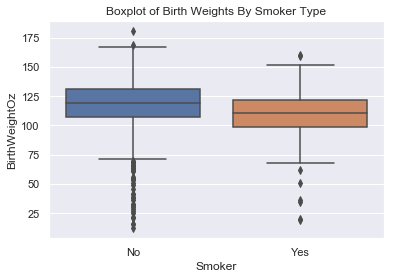

In [18]:
#boxplot
sn.boxplot(x="Smoker", y="BirthWeightOz", data=data).set_title("Boxplot of Birth Weights By Smoker Type")

Running: Mom Age
Running: Weight Gained
Running: Weeks


<Figure size 432x288 with 0 Axes>

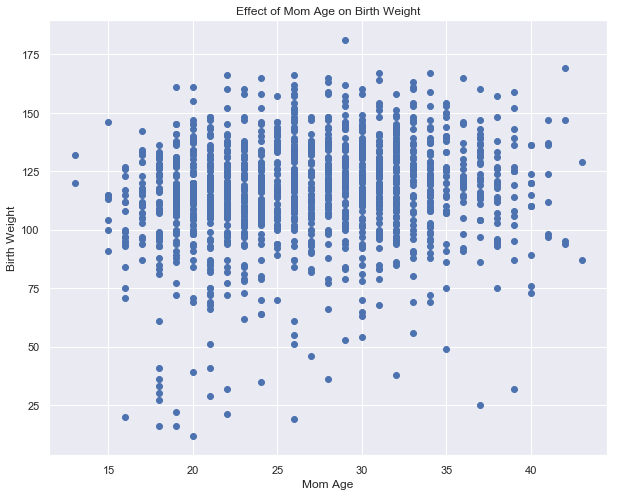

<Figure size 432x288 with 0 Axes>

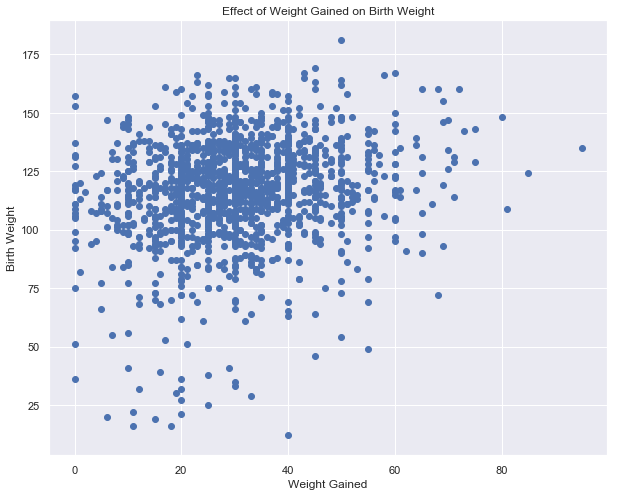

<Figure size 432x288 with 0 Axes>

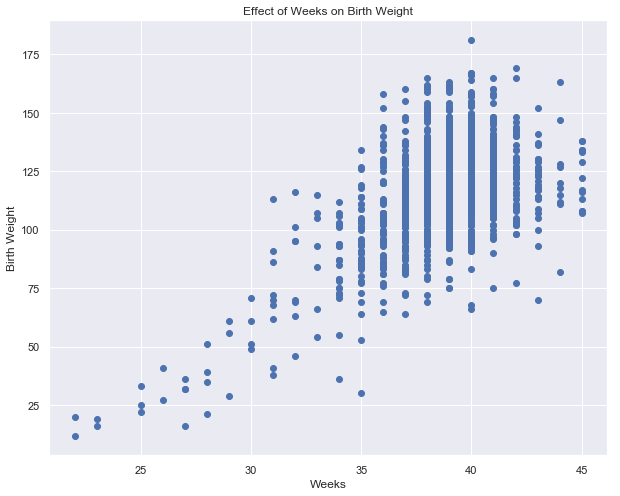

In [19]:
pdf = matplotlib.backends.backend_pdf.PdfPages("scatterplots.pdf")

scatter_columns = ['Mom Age', 'Weight Gained', 'Weeks']

for i in scatter_columns:
    print("Running: {}".format(i))
    plot2 = plt.figure()
    plt.figure(figsize=(10,8))
    plt.title("Effect of {} on Birth Weight".format(i))
    plt.xlabel(i)
    plt.ylabel('Birth Weight')
    plt.scatter(data[i], data['BirthWeightOz'])
    pdf.savefig(plot2)
    
pdf.close()

###### Correlation Matrix

In [20]:
#Run correlation metrics
corrmatrix(data)

,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie
Plural,1,-0.0066,0.08,-0.33,-0.034,0.094,-0.054,-0.34,0.38,0.3
Sex,-0.0066,1,0.019,0.051,-0.011,-0.0084,-0.007,-0.048,-0.027,-0.028
Mom Age,0.08,0.019,1,0.037,-0.47,0.01,-0.11,0.15,-0.071,-0.063
Weeks,-0.33,0.051,0.037,1,-0.064,0.06,-0.032,0.59,-0.53,-0.71
Marital,-0.034,-0.011,-0.47,-0.064,1,-0.031,0.16,-0.17,0.086,0.096
Weight Gained,0.094,-0.0084,0.01,0.06,-0.031,1,0.003,0.19,-0.1,-0.034
Smoke,-0.054,-0.007,-0.11,-0.032,0.16,0.003,1,-0.13,0.062,0.039
BirthWeightOz,-0.34,-0.048,0.15,0.59,-0.17,0.19,-0.13,1,-0.67,-0.5
Low,0.38,-0.027,-0.071,-0.53,0.086,-0.1,0.062,-0.67,1,0.5
Premie,0.3,-0.028,-0.063,-0.71,0.096,-0.034,0.039,-0.5,0.5,1


### Setup and Run Model

###### Create squared term and x and y data splits

In [21]:
#Create Squared term for weeks
data['Weeks Squared'] = data['Weeks'] ** 2

In [22]:
#Lists for splitting data into x and y sets

x_variables = ['Gender', 'Premie Baby', 'Marital Status', 'Smoker', 'MomRace', 'Weeks', 'Weeks Squared']
y_variable = 'BirthWeightOz'

categorical_columns = ['Gender', 'Premie Baby', 'Marital Status', 'Smoker', 'MomRace']
elements_to_drop = ['Male', 'No', 'Not Married', 'No', 'White']

#Run function to get x and y split
x, y = x_y_split(data, x_variables, y_variable, categorical_columns, elements_to_drop)

C:\Users\nickp\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
ols_model = create_ols_model(x, y)
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          BirthWeightOz   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     257.6
Date:                Fri, 27 Nov 2020   Prob (F-statistic):          1.88e-289
Time:                        23:44:31   Log-Likelihood:                 624.71
No. Observations:                1409   AIC:                            -1229.
Df Residuals:                    1399   BIC:                            -1177.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.0866      0.330    -15.426      0.000      -5.733      -4.440
Weeks                      0.4766      0.018     27.038      0.000       0.442       0.511
Weeks Squared             -0.0057      0.000    -23.975      0.000      -0.006      -0.005
Gender_Female             -0.0287      0.008     -3.447      0.001      -0.045      -0.012
Premie Baby_Yes           -0.0136      0.018     -0.763      0.446      -0.049       0.021
Marital Status_Married     0.0240      0.010      2.417      0.016       0.005       0.043
Smoker_Yes                -0.0486      0.012     -3.979      0.000      -0.073      -0.025
MomRace_Black             -0.0343      0.011     -3.069      0.002      -0.056      -0.012
MomRace_Hispanic          -0.0127      0.014     -0.887      0.375      -0.041       0.015
MomRace_Other             -0.0033      0.023     -0.141      0.888      -0.049       0.043
==============================================================================
Omnibus:                      280.502   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1245.313
Skew:                          -0.876   Prob(JB):                    3.83e-271
Kurtosis:                       7.260   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#calculate vif scores
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif

,VIF Factor,features
0,6305.563638,const
1,126.876896,Weeks
2,123.284557,Weeks Squared
3,1.003855,Gender_Female
4,2.073164,Premie Baby_Yes
5,1.287039,Marital Status_Married
6,1.079400,Smoker_Yes
7,1.287885,MomRace_Black
8,1.143283,MomRace_Hispanic
9,1.030144,MomRace_Other


In [25]:
#Get Predictions for test dataframe      

predictions_df, coefficient_df = get_predictions(ols_model, x, y)

In [26]:
#Get Metrics from the model results
mape, mse, rmse, dof_ratio, metrics_df = regression_metrics(ols_model, x, y)
print('MAPE: {}'.format(mape))
print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))
print('DOF Ratio: {}'.format(dof_ratio))

MAPE: 2.4854325696365063
MSE: 0.024122444434251347
RMSE: 0.1553140187949927
DOF Ratio: 156.55555555555554


In [27]:
#Calculate when effect of weeks becomes negative
coefficient_df.head()

squared_terms = ['Weeks', 'Weeks Squared']

inflection_point_df = coefficient_df.pivot_table(values='Coef.',
                                                 columns=['Variables'],
                                                 aggfunc=np.sum).reset_index()


inflection_point_weeks = inflection_point_df[squared_terms[0]].values[0] / (2 * -inflection_point_df[squared_terms[1]].values[0])
print("After {} weeks, weeks starts to have a negative impact on birth weight".format(round(inflection_point_weeks, 3)))

After 41.655 weeks, weeks starts to have a negative impact on birth weight


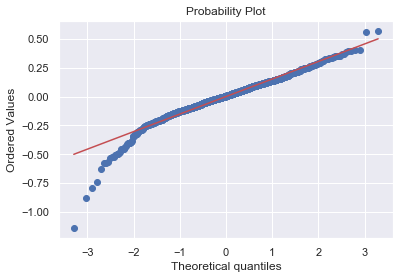

In [28]:
#Check for normal distribution of residuals
qq_plot(predictions_df, 'Residual')

In [29]:
#Write Dataframes to excel
writer = pd.ExcelWriter(r'C:\Users\nickp\Desktop\data science\baby weight\baby weight regression output.xlsx')

coefficient_df.to_excel(writer, "Coefficients", index=False)
predictions_df.to_excel(writer, "Predictions", index=False)
vif.to_excel(writer, "VIF", index=False)
metrics_df.to_excel(writer, "metrics", index=False)

writer.save()